In [3]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


### Problem 1 Astrometry and Photometry with Photutils

The file "star_nopsfsub.fits" is an unsaturated image of the star (which should be in the middle of the image).  the file "psfsub.fits" is the same image with the stellar halo removed to flatten the background and reveal a planet-mass companion nearly due-west of the star (it's at an x position of about 320).

Assume that the pixel scale is roughly 9.952 milliarcseconds/pixel and that the image is rotated perfectly north-up, east-left.

* read in this file using astropy functions

* using photutils, compute the centroid of the planet-mass companion's position in pixel values (x and y).   Then, given the pixel scale, compute its position in arc-seconds in units [East, North] _relative_ to the star. 

    (e.g. if its position were 0.5 arcseconds east and -0.7 arcseconds south of the star then you would report this as [East, North] = [0.5,-0.7]).
    
    
* using photutils, plot the radial-profile of the star.  Find where the star's brightness roughly (emphasis on **roughly**!) decreases to about half its peak value: round up to the nearest integer and set this value to be the aperture radius.


* Compute photometry of the star and the companion with this aperture radius both in units of counts.  Then compute the contrast between the star and the planet in units of magnitudes (note: do not overthink this: it's as simple as it sounds).


Hints: 
* to figure out a good initial guess for the centroid positions, try displaying the image using Matplotlib: the notes give a good recipe for how to do this.
* look at the notes on photutils VERY closely to figure out how to plot the radial profile.   The answer for the half-peak value will be in between two integers: again, round up to get the aperture radius you should use.
* you do not need to compute astrometric errors or photometric errors


In [4]:
from photutils import centroids
from photutils.centroids import *
import photutils

In [9]:
starimage=(fits.open('star_nopsfsub.fits'))[0].data
planetimage=(fits.open('psfsub.fits'))[0].data

In [ ]:
#visualize the planet's position to estimate initial position
plt.figure(figsize=(8, 8))
clims=np.nanpercentile(planetimage,[10,99])

plt.imshow(planetimage, clim=clims)

(194.5, 205.5)

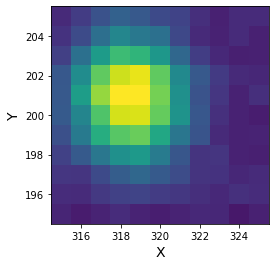

In [20]:
#its roughly at 320, 200?
#now zoom in

x0=320; y0=200
#define a narrow window
window=11/2.

#slightly greater range to see centroid more clearly
clims2=np.nanpercentile(planetimage,[10,99.7])
plt.imshow(planetimage, clim=clims2)
plt.xlabel('X',fontsize=14)
plt.ylabel('Y',fontsize=14)
plt.xlim(x0-window,x0+window)
plt.ylim(y0-window,y0+window)

In [21]:
#looks like a position of about 319,201 or so.
#now centroid based off of this initial guess

xo=319
yo=201


In [25]:
#centroid the planet

#1d gaussian fit to marginal x & y distributions
x1d,y1d = centroid_sources(planetimage,xo,yo,box_size=11,centroid_func=centroid_1dg)
print("the planet has an x centroid position of {0:.3f} and y centroid position of {1:.3f}".format(x1d[0],y1d[0]))

the planet has an x centroid position of 318.504 and y centroid position of 200.834


(195.5, 206.5)

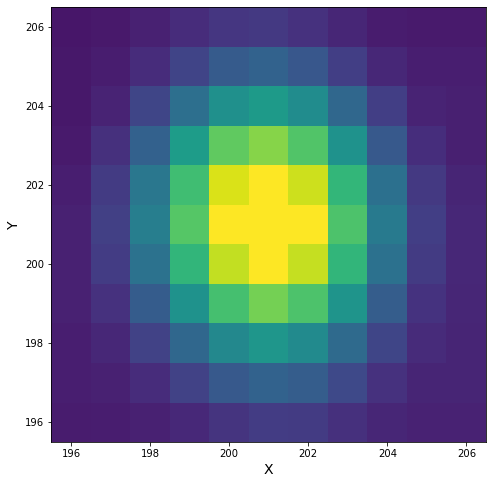

In [31]:
#do a centroid estimate for the star to confirm it's actually in the center?

#visualize the planet's position to estimate initial position
plt.figure(figsize=(8, 8))
clims=np.nanpercentile(starimage,[10,99.9975])

window=11/2.

x0s=(starimage.shape)[1]//2
y0s=(starimage.shape)[0]//2
plt.imshow(starimage, clim=clims)
plt.xlabel('X',fontsize=14)
plt.ylabel('Y',fontsize=14)
plt.xlim(x0s-window,x0+window)
plt.ylim(y0s-window,y0+window)

In [33]:
#looks really close to dead-center.  Let's confirm

#1d gaussian fit to marginal x & y distributions for star
x1ds,y1ds = centroid_sources(starimage,x0s,y0s,box_size=11,centroid_func=centroid_1dg)
print("the star has an x centroid position of {0:.3f} and y centroid position of {1:.3f}".format(x1ds[0],y1ds[0]))

print("this is very close to the exact center of the iamge")

the star has an x centroid position of 200.985 and y centroid position of 200.996


In [41]:
#relative astrometry of the planet

east,north=-1*(x1d[0]-x1ds[0])*0.009952, (y1d[0]-y1ds[0])*0.009952


east2,north2=-1*(x1d[0]-(planetimage.shape)[1]//2)*0.009952, (y1d[0]-(planetimage.shape)[0]//2)*0.009952

In [43]:
print(east,north)
print(east2,north2)

-1.169549309691501 -0.0016201057110288557
-1.1694042702175524 -0.001656971965447926


In [46]:
#now, photometry
from photutils import CircularAperture




#from photutils import aperture_photometry
from photutils.aperture import aperture_photometry

/var/folders/jd/2nq0dfy94lsddczv0kg2y33h0000gn/T/ipykernel_57132/2253669844.py:2: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import CircularAperture


In [62]:
planetposition = (x1d[0],y1d[0])  # (x, y) pixel position for planet
starposition=(x1ds[0],y1ds[0]) # (x, y) pixel position for star
#radius = 5  # pixels

radii = list(np.arange(2,10))

planet_apertures = [CircularAperture(planetposition, r=r) for r in radii]
star_apertures = [CircularAperture(starposition, r=r) for r in radii]
#planet_aperture = CircularAperture(planetposition, r=radius)


Text(0.5, 0, 'Pixels')

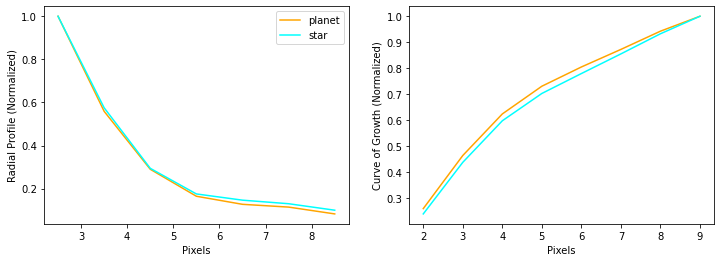

In [63]:
from photutils.profiles import RadialProfile,CurveOfGrowth

rpp=RadialProfile(planetimage,(x1d[0],y1d[0]),radii,error=None,mask=None)
cogp=CurveOfGrowth(planetimage,[x1d[0],y1d[0]],radii,error=None,mask=None)

rps=RadialProfile(starimage,(x1ds[0],y1ds[0]),radii,error=None,mask=None)
cogs=CurveOfGrowth(starimage,[x1ds[0],y1ds[0]],radii,error=None,mask=None)

fig,axes=plt.subplots(1,2,figsize=(12,4))
axes[0].plot(rpp.radius,rpp.profile/np.max(rpp.profile),color='orange',label='planet')
axes[0].plot(rps.radius,rps.profile/np.max(rps.profile),color='cyan',label='star')
axes[0].set_ylabel('Radial Profile (Normalized)')
axes[0].set_xlabel('Pixels')
axes[0].legend(loc='best')
axes[1].plot(cogp.radius,cogp.profile/np.max(cogp.profile),color='orange',label='planet')
axes[1].plot(cogs.radius,cogs.profile/np.max(cogs.profile),color='cyan',label='star')
axes[1].set_ylabel('Curve of Growth (Normalized)')
axes[1].set_xlabel('Pixels')

In [67]:
#Radial profile analysis sets the 1/2 peak value to be roughly 3.5 pixels. Round up to 4 pixels
# aperture photometry


star_aperture_final=CircularAperture(starposition, r=4)
planet_aperture_final=CircularAperture(planetposition, r=4)
starphot = aperture_photometry(starimage, star_aperture_final)
planetphot = aperture_photometry(planetimage, planet_aperture_final)

In [70]:
print(planetphot)
print(starphot)

 id      xcenter           ycenter          aperture_sum   
           pix               pix                           
--- ----------------- ------------------ ------------------
  1 318.5044483739502 200.83350362083522 30557.612022472164
 id      xcenter            ycenter          aperture_sum   
           pix                pix                           
--- ------------------ ------------------ ------------------
  1 200.98542609787495 200.99629559340644 10666315.737471849


In [76]:
#contrast
planet_flux=planetphot['aperture_sum'].value

star_flux=starphot['aperture_sum'].value


contrast=-2.5*np.log10(planet_flux/star_flux)
contrast

array([6.35723756])